# How can different types of omics data in the NMDC database be related?

This notebook is an example of how different omics data types may be linked via commonly used annotation vocabularies and investigated together. In this notebook we explore biomolecules and KEGG pathways identified in a set of samples that have processed metagenomic, metaproteomics, and metabolomics data available in the NMDC Data Portal.

NOTE: This notebook uses the KEGGREST R package to interface with the KEGG API. Use of the KEGG API and KEGGREST is restricted to academic users. Non-academic users must obtain a commercial license. (See https://www.kegg.jp/kegg/legal.html) The National Microbiome Data Collaborative use of KEGG is covered by license (license information).

In [ ]:
.libPaths(c(.libPaths(), "../../renv/library/*/R-*/*"))
suppressPackageStartupMessages({
library(dplyr, warn.conflicts = FALSE)
library(tidyr, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
library(readr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(purrr)
library(jsonlite)
library(KEGGREST)
library(httr)
library(circlize)
})

## 1. Retrieve data from the NMDC database using API endpoints

### Choose data to retrieve

The NMDC data portal (https://data.microbiomedata.org/) allow us to filter data and samples according to many criteria. In this case, we use the Data Type filters (upset plot) to identify samples that have metagenomics, metaproteomics, and metabolomics data. This returns 33 samples from the study "Riverbed sediment microbial communities from the Columbia River, Washington, USA" (https://data.microbiomedata.org/details/study/nmdc:sty-11-aygzgv51).

### Retrieve and filter data for Columbia River sediment study

The study page linked above has the NMDC study identifier in the URL: `nmdc:sty-11-aygzgv51`. We will use the function `get_data_objects_for_study` (defined in `utility_functions.R`) to retrieve all records that represent data. This includes raw data files (e.g. FASTQ or mass spectra files) as well as processed data results output by the NMDC workflows.


In [2]:
# Retrieve all data objects associated with this study

# TODO: merge in R script PR so that this call can use the function I wrote for it
dobj <- jsonlite::fromJSON('https://api.microbiomedata.org/data_objects/study/nmdc%3Asty-11-aygzgv51') %>% 
  unnest(cols = c(data_objects))

In this case, we want to look at the processed data results for our three omics types of interest. Specifically, we want the files containing KEGG Orthology and Enzyme Commission annotations. 

One way of further identifying a NMDC `DataObject` record is by looking at its slot `data_object_type` (https://microbiomedata.github.io/nmdc-schema/data_object_type/), which contains a value from `FileTypeEnum` (https://microbiomedata.github.io/nmdc-schema/FileTypeEnum/). Based on the descriptions of `FileTypeEnum` permissible values we want to filter for results files with the following `data_object_type` values:

| Value | Description |
|:-----:|:-----------:|
|Annotation Enzyme Commission|Tab delimited file for EC annotation|
|Annotation KEGG Orthology|Tab delimited file for KO annotation|
|GC-MS Metabolomics Results|GC-MS-based metabolite assignment results table|
|Protein Report|Filtered protein report file|

In [3]:
dobj <- dobj %>%
  # Filter to biosamples with metagenome EC annotations, metagenome KO 
  # annotations, metaproteomics results, and metabolomics results
  group_by(biosample_id) %>%
  filter("Annotation Enzyme Commission" %in% data_object_type &
           "Annotation KEGG Orthology" %in% data_object_type & 
           "GC-MS Metabolomics Results" %in% data_object_type &
           "Protein Report" %in% data_object_type) %>%
  ungroup() %>%
  
  # Remove uninformative columns for simpler dataframe
  select(-c(alternative_identifiers, in_manifest, was_generated_by))

### Download selected results files
 
Now we can use the `url` slot from the filtered `DataObject` records to read in all of the files containing the annotations of interest.

In [4]:
results_by_biosample <- dobj %>%
  
  # Filter to desired results file types and create one URL column per type
  filter(data_object_type %in% c("Annotation Enzyme Commission", "Annotation KEGG Orthology",
                                 "GC-MS Metabolomics Results", "Protein Report")) %>%
  select(biosample_id, data_object_type, url) %>%
  pivot_wider(names_from = data_object_type, values_from = url) %>%
  
  # Read in the TSV/CSV results files
  # Add in column names from the IMG genome download README
  mutate(metag_ec_results = lapply(
    .$`Annotation Enzyme Commission`, 
    function(x) { 
      d <- read_tsv(x, col_names = FALSE, show_col_types = FALSE)
      names(d) <- c("gene_id", "img_ko_flag", "EC", "percent_identity",
                    "query_start", "query_end", "subj_start", "subj_end",
                    "evalue", "bit_score", "align_length")
      d
      })) %>%
  
  mutate(metag_ko_results = lapply(
    .$`Annotation KEGG Orthology`, 
    function(x) { 
      d <- read_tsv(x, col_names = FALSE, show_col_types = FALSE)
      names(d) <- c("gene_id", "img_ko_flag", "ko_term", "percent_identity",
                    "query_start", "query_end", "subj_start", "subj_end",
                    "evalue", "bit_score", "align_length")
      d
      })) %>%

  mutate(metap_results = lapply(.$`Protein Report`, read_tsv, col_names = TRUE, show_col_types = FALSE)) %>%
  mutate(metab_results = lapply(.$`GC-MS Metabolomics Results`, read_csv, col_names = TRUE, show_col_types = FALSE))


Each of the downloaded data files contains lots of information including the KO, EC, or KEGG Compound identifiers.

In [5]:

# View a snippet of the metagenome KEGG Orthology annotations file
head(results_by_biosample$metag_ko_results[[1]])

gene_id,img_ko_flag,ko_term,percent_identity,query_start,query_end,subj_start,subj_end,evalue,bit_score,align_length
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
nmdc:wfmgan-11-z0q72297.1_000001_7_501,2999021309,KO:K09129,96.95,1,164,1,164,1.2e-113,370,164
nmdc:wfmgan-11-z0q72297.1_000001_822_2396,2999016232,KO:K08482,57.28,1,522,17,536,1.4e-211,685,522
nmdc:wfmgan-11-z0q72297.1_000001_2919_3773,2999016149,KO:K07652,45.16,15,267,512,790,1.8e-71,260,253
nmdc:wfmgan-11-z0q72297.1_000001_8181_8969,2999039711,KO:K07238,80.84,2,262,32,291,5.4e-144,466,261
nmdc:wfmgan-11-z0q72297.1_000002_2920_3669,2999021898,KO:K07090,80.97,3,249,1,247,6.7e-141,456,247
nmdc:wfmgan-11-z0q72297.1_000002_5075_5563,2999019508,KO:K04750,75.64,3,158,2,157,9.2e-84,284,156


From each results table we can extract the unique list of genes/proteins/metabolites identified in that sample.

In [6]:
# Metagenome annotations - Enzyme Commission
metag_ec_unique_df <- results_by_biosample %>%
  distinct(biosample_id, .keep_all = TRUE) %>%

  # Save a unique vector of annotations by type for each sample for searching later
  mutate(metag_ec_unique = lapply(.$metag_ec_results, 
                                  FUN = function(x) { sort(unique(x$EC)) })) %>%
  select(biosample_id, metag_ec_results, metag_ec_unique)



# Metagenome annotations - KEGG Orthology
metag_ko_unique_df <- results_by_biosample %>%
  distinct(biosample_id, .keep_all = TRUE) %>%

  # Save a unique vector of annotations by type for each sample for searching later
  mutate(metag_ko_unique = lapply(.$metag_ko_results, 
                                  FUN = function(x) { sort(unique(x$ko_term)) })) %>%
  select(biosample_id, metag_ko_results, metag_ko_unique)



# Metaproteome annotations - Enzyme Commission
metap_ec_unique_df <- results_by_biosample %>%
  distinct(biosample_id, .keep_all = TRUE) %>%

  # Save a unique vector of annotations by type for each sample for searching later
  mutate(metap_ec_unique = lapply(
    .$metap_results, 
    FUN = function(x) { sort(unique(x$EC_Number)) %>% strsplit(",") %>% unlist() })) %>%
  select(biosample_id, metap_results, metap_ec_unique)



# Metabolome annotations - KEGG Compound
metab_ko_unique_df <- results_by_biosample %>%
  distinct(biosample_id, .keep_all = TRUE) %>%

  # Save a unique vector of annotations by type for each sample for searching later
  mutate(metab_ko_unique = lapply(.$metab_results, 
                                  FUN = function(x) { sort(unique(x$`Kegg Compound ID`)) })) %>%
  select(biosample_id, metab_results, metab_ko_unique)


# rm(results_by_biosample)

## 2. Get IDs from other KEGG databases

Now we will use the KEGGREST package (available on Bioconductor) to make calls to the KEGG API. Using the annotations provided in the workflow results, we can look up the corresponding annotations in other KEGG databases to start drawing connections between biomolecule identifications.

### Gather metabolite information

First we will find all of the Enzyme Commission numbers available for each identified compound. These EC numbers represent enzymes involved in recorded reactions that produce the compound of interest.
Then we will do the same to pull all of the modules and pathways that each compound is a part of. 

KEGG modules are functional units of gene sets and KEGG Pathways are manually drawn maps that represent known molecular interactions for biologically interesting processes. Later we will use the module and pathway IDs to see where our identified biomolecules interact.

In [ ]:
# For each sample, assemble a dataframe of metabolite information

# Pre-allocate an empty list for metabolite dataframes
metabolite_annotations_list <- vector(mode = "list", length = length(metab_ko_unique_df$biosample_id))

for (biosample in 1:length(metab_ko_unique_df$biosample_id)) {

  unique_metabolites <- metab_ko_unique_df$metab_ko_unique[[biosample]]

  # Get EC ids for each metabolite
  ec_from_metabolites <- keggLink("enzyme", unique_metabolites)

  ec_from_metabolites <- data.frame(compound_id = names(ec_from_metabolites),
                                    ec_id = ec_from_metabolites) %>%
    nest(.by = compound_id, .key = "ec_id")

  # Get modules for each metabolite
  modules_from_metabolites <- keggLink("module", unique_metabolites)

  modules_from_metabolites <- data.frame(compound_id = names(modules_from_metabolites),
                                        module_id = modules_from_metabolites) %>%
    nest(.by = compound_id, .key = "module_id")


  # Get pathways for each metabolite
  pathways_from_metabolites <- keggLink("pathway", unique_metabolites)

  pathways_from_metabolites <- data.frame(compound_id = names(pathways_from_metabolites),
                                          pathway_id = pathways_from_metabolites) %>%
    nest(.by = compound_id, .key = "pathway_id")

  # Join compound, EC, module, pathway IDs into one dataframe
  metabolite_annotations <- data.frame(compound_id = paste0("cpd:", unique_metabolites)) %>%
    left_join(ec_from_metabolites) %>%
    left_join(modules_from_metabolites) %>%
    left_join(pathways_from_metabolites) %>%
    mutate(compound_trimmed = unique_metabolites) %>%
    
    # Search for the EC IDs in the unique identification lists 
    # for the other biomolecules in this sample
    mutate(In_Metag_Annotations = vapply(.$ec_id, function(x) { any(x$ec_id %in% tolower(metag_ec_unique_df$metag_ec_unique[[biosample]])) },
                            FUN.VALUE = TRUE)) %>%
    mutate(In_Prot_Annotations = vapply(.$ec_id, function(x) { any(x$ec_id %in% tolower(metap_ec_unique_df$metap_ec_unique[[biosample]])) },
                            FUN.VALUE = TRUE))

  # Save dataframe to list
  metabolite_annotations_list[[biosample]] <- metabolite_annotations
}

### Gather protein information

Next we will do the same thing for proteins in each sample - starting with the KO and EC IDs from the NMDC annotation workflow, identify the modules and pathways each protein is associated with, and what corresponding metabolites/genes were identified in this sample.

In [ ]:
# For each sample, assemble a dataframe of protein information

# Pre-allocate an empty list for protein dataframes
protein_annotations_list <- vector(mode = "list", length = length(metap_ec_unique_df$biosample_id))

for (biosample in 1:length(metap_ec_unique_df$biosample_id)) {

  # Gather protein annotations from workflow output
  protein_annotations <- metap_ec_unique_df$metap_results[[biosample]] %>%
    select(KO, EC_Number) %>%
    rename(ko_id = KO, ec_id = EC_Number) %>%
    mutate(ec_id = trimws(strsplit(ec_id, ","))) %>%
    filter(if_any(everything(), ~ !is.na(.))) %>%
    distinct() %>%
    mutate(ko_trimmed = substring(ko_id, 4))
  
  unique_proteins <- protein_annotations$ko_trimmed
  
  # Get modules for each protein
  modules_from_proteins <- keggLink("module", unique_proteins)
  
  modules_from_proteins <- data.frame(ko_id = toupper(names(modules_from_proteins)),
                                      module_id = modules_from_proteins) %>%
    nest(.by = ko_id, .key = "module_id")
  
  
  # Get pathways for each protein
  pathways_from_proteins <- keggLink("pathway", unique_proteins)
  
  pathways_from_proteins <- data.frame(ko_id = toupper(names(pathways_from_proteins)),
                                       pathway_id = pathways_from_proteins) %>%
    nest(.by = ko_id, .key = "pathway_id")

  
  # Join KO, EC, module, pathway IDs into one dataframe
  protein_annotations <- protein_annotations %>%
    left_join(modules_from_proteins) %>%
    left_join(pathways_from_proteins) %>%
    
    # Search for corresponding biomolecules in other data types for this sample
    mutate(In_Metab_Annotations = vapply(.$ec_id, function(x) { any(tolower(x) %in% unique(unlist(metabolite_annotations_list[[biosample]]$ec_id))) },
                                         FUN.VALUE = TRUE)) %>%
    mutate(In_Metag_Annotations = vapply(.$ko_id, function(x) { any(x %in% unique(metag_ko_unique_df$metag_ko_unique[[biosample]])) },
                                         FUN.VALUE = TRUE))
  
  # Save dataframe to list
  protein_annotations_list[[biosample]] <- protein_annotations
}

### Gather gene information

Finally we will create the same list of dataframes for the metagenomes in each sample.

In [ ]:
# For each sample, assemble a dataframe of gene information

# Pre-allocate an empty list for gene dataframes
gene_annotations_list <- vector(mode = "list", length = length(metag_ko_unique_df$biosample_id))

for (biosample in 1:1) { #length(metag_ko_unique_df$biosample_id)) {

  # Gather gene annotations from workflow output
  # Join KO and EC annotation dataframes using the NMDC workflow generated "gene_id"
  metag_annotations <- full_join(metag_ko_unique_df$metag_ko_results[[biosample]], 
                                 metag_ec_unique_df$metag_ec_results[[biosample]],
                                 by = join_by("gene_id")) %>%
    distinct(ko_term, EC) %>%
    filter(!is.na(EC)) %>%
    nest(.by = ko_term, .key = "EC") %>%
    rename(ko_id = ko_term, ec_id = EC) %>%
    
    mutate(ko_trimmed = substring(ko_id, 4)) %>%
  
    mutate(In_Metab_Annotations = vapply(.$ec_id, function(x) { any(tolower(x) %in% unique(unlist(metabolite_annotations_list[[biosample]]$ec_id))) },
                             FUN.VALUE = TRUE)) %>%
    mutate(In_Prot_Annotations = ko_id %in% protein_annotations_list[[biosample]]$ko_id)
  
  
  # Get modules for each gene
  # Break up vector of KO IDs, HTTP request URL gets too long
  modules_from_genes <- split(metag_annotations$ko_trimmed, 
                              ceiling(seq_along(metag_annotations$ko_trimmed)/50)) %>%
    lapply(FUN = function(x) { keggLink("module", x) }) %>%
    list_c()
  
  
  modules_from_genes <- data.frame(ko_id = toupper(names(modules_from_genes)),
                                   module_id = modules_from_genes) %>%
    nest(.by = ko_id, .key = "module_id")
  
  
  # Get pathways for each gene
  pathways_from_genes <- split(metag_annotations$ko_trimmed, 
                              ceiling(seq_along(metag_annotations$ko_trimmed)/50)) %>%
    lapply(FUN = function(x) { keggLink("pathway", x) }) %>%
    list_c()
  
  pathways_from_genes <- data.frame(ko_id = toupper(names(pathways_from_genes)),
                                    pathway_id = pathways_from_genes) %>%
    nest(.by = ko_id, .key = "pathway_id")
  
  
  # Add modules and pathways to gene annotations dataframe
  metag_annotations <- metag_annotations %>%
    left_join(modules_from_genes) %>%
    left_join(pathways_from_genes)
  
  gene_annotations_list[[biosample]] <- metag_annotations

}


## Visualize shared biomolecule identifications

Generate sector and arc start/end values for the circos plot


In [19]:
# Select an example biosample
example_gene <- gene_annotations_list[[1]]
example_prot <- protein_annotations_list[[1]]
example_metab <- metabolite_annotations_list[[1]]

# Scale sectors so that arc widths are proportional rather than absolute
# There are way more gene identifications than others so it gets hard to visualize as absolute counts
largest_sector_xlim <- max(length(example_gene$ko_id),
                           length(example_prot$ko_id),
                           length(example_metab$compound_id))

# Gene sector
gene_sector_xlim <- (length(example_gene$ko_id))

gene_sector_prot_count <- (sum(example_gene$In_Prot_Annotations)) * (largest_sector_xlim / gene_sector_xlim)
gene_sector_both_count <- (nrow(filter(example_gene, In_Metab_Annotations & In_Prot_Annotations))) * (largest_sector_xlim / gene_sector_xlim)
gene_sector_metab_count <-(sum(example_gene$In_Metab_Annotations)) * (largest_sector_xlim / gene_sector_xlim)

# Prot sector
prot_sector_xlim <- length(example_prot$ko_id)

prot_sector_metab_count <- sum(example_prot$In_Metab_Annotations) * (largest_sector_xlim / prot_sector_xlim)
prot_sector_both_count <- nrow(filter(example_prot, In_Metab_Annotations & In_Metag_Annotations)) * (largest_sector_xlim / prot_sector_xlim)
prot_sector_gene_count <-sum(example_prot$In_Metag_Annotations) * (largest_sector_xlim / prot_sector_xlim)


# Metab sector
metab_sector_xlim <- length(example_metab$compound_id)

metab_sector_gene_count <- sum(example_metab$In_Metag_Annotations) * (metab_sector_xlim / prot_sector_xlim)
metab_sector_both_count <- nrow(filter(example_metab, In_Metag_Annotations & In_Prot_Annotations)) * (metab_sector_xlim / prot_sector_xlim)
metab_sector_prot_count <-sum(example_metab$In_Prot_Annotations) * (metab_sector_xlim / prot_sector_xlim)

# Reset sector sizes to scaled value
gene_sector_xlim <- largest_sector_xlim
prot_sector_xlim <- largest_sector_xlim
metab_sector_xlim <- largest_sector_xlim



Generate a chord diagram showing which biomolecules in each omics type have connections to each other omics type



Note: The first link end is drawn out of sector 'genes'.

Note: The second link end is drawn out of sector 'proteins'.

Note: The first link end is drawn out of sector 'proteins'.

Note: The first link end is drawn out of sector 'metabolites'.



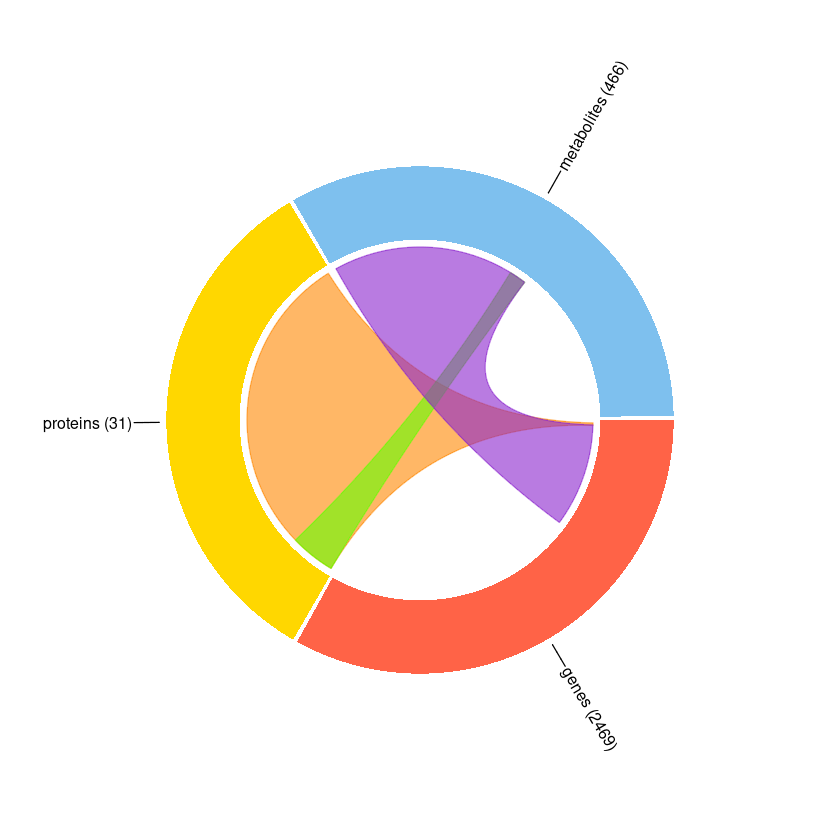

In [21]:
plot_sector_names <- c("genes", "proteins", "metabolites")
 
# Create data
data = data.frame(
    sectors = c(rep("genes", gene_sector_xlim),
               rep("proteins", prot_sector_xlim),
               rep("metabolites", metab_sector_xlim)),
    x = c(seq(1:gene_sector_xlim),
          seq(1:prot_sector_xlim),
          seq(1:metab_sector_xlim)),
    y = c(seq(1:gene_sector_xlim),
          seq(1:prot_sector_xlim),
          seq(1:metab_sector_xlim))) %>%
  mutate(sectors = factor(sectors, levels = plot_sector_names))
 
# Initialize the plot.
circos.initialize(factors = data$sectors, x = data$x)

circos.labels(plot_sector_names, 
              x = c(gene_sector_xlim/2, prot_sector_xlim/2, metab_sector_xlim/2), 
              labels = c(paste0("genes (", nrow(example_gene), ")"),
                         paste0("proteins (", nrow(example_prot), ")"), 
                         paste0("metabolites (", nrow(example_metab), ")")),
              side = "outside")

 
# Build the regions of track #1
circos.trackPlotRegion(factors = data$sectors, y=data$y, bg.col = c("tomato", "gold", "skyblue2") , bg.border = NA)
 
# Add a link between a zone and another
circos.link("genes", c(0, gene_sector_prot_count), 
            "proteins", c(prot_sector_metab_count - prot_sector_both_count, 
                          prot_sector_metab_count - prot_sector_both_count + prot_sector_gene_count), 
            col = "#ff870099")


circos.link("proteins", c(0, prot_sector_metab_count), 
            "metabolites", c(metab_sector_gene_count - metab_sector_both_count,
                             metab_sector_gene_count - metab_sector_both_count + metab_sector_prot_count), 
            col = "#63ff0099")



circos.link("metabolites", c(0, metab_sector_gene_count), 
            "genes", c(gene_sector_prot_count - gene_sector_both_count,
                       gene_sector_prot_count - gene_sector_both_count + gene_sector_metab_count), 
            col = "#8b24cd99")